## Classification using MLP including tempo feature

In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import IPython.display as ipd

import matplotlib.pyplot as plt

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import (train_test_split, GridSearchCV, RandomizedSearchCV)
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score)

from collections import Counter
import utils

#### Again we use medium+small to get the largest set of training exemplars

Note: will be unbalanced

In [6]:
RANDOM_STATE = 53

(features, tracks) = utils.load_features()
tempo = utils.load_tempo('large')

small = tracks[('set', 'subset')] == 'small'
medium = tracks[('set', 'subset')].isin(['small','medium'])
X = features[medium]

# merge tempo feature
tempo = tempo.dropna()
X = X.merge(tempo, on='track_id')
y = tracks[medium][('track','genre_top')]
y = y[y.index.isin(X.index)]

# arbitrarily prune genres with minimal support
prune = ~y.isin(['Spoken','Blues','Easy Listening'])
y = y[prune]
X = X[prune]
print(X.shape, y.shape)

(24772, 525) (24772,)


#### Train/Test splits with up/downsampling

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2,
                                                    random_state=RANDOM_STATE,
                                                    shuffle=True,
                                                    stratify=y)
scaler = MinMaxScaler(copy=False)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# now resample the training set

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# oversample all genres < 500 to 500
strategy = {}
for genre, count in Counter(y_train).items():
    if (count < 500):
        strategy[genre] = 500
over = RandomOverSampler(sampling_strategy=strategy)
X_train, y_train = over.fit_resample(X_train, y_train)

# undersample all genres > 3500 to 3500
strategy = {}
for genre, count in Counter(y).items():
    if (count > 3500):
        strategy[genre] = 3500
under = RandomUnderSampler(sampling_strategy=strategy)
X_train, y_train = under.fit_resample(X_train, y_train)

Counter(y_train)

Counter({'Classical': 500,
         'Country': 500,
         'Electronic': 3500,
         'Experimental': 1800,
         'Folk': 1214,
         'Hip-Hop': 1758,
         'Instrumental': 1079,
         'International': 814,
         'Jazz': 500,
         'Old-Time / Historic': 500,
         'Pop': 949,
         'Rock': 3500,
         'Soul-RnB': 500})

#### Train with best from MLP investigation

                     precision    recall  f1-score   support

          Classical       0.70      0.87      0.78       124
            Country       0.38      0.51      0.44        35
         Electronic       0.71      0.74      0.73      1262
       Experimental       0.39      0.53      0.45       450
               Folk       0.58      0.68      0.63       304
            Hip-Hop       0.66      0.72      0.69       439
       Instrumental       0.44      0.46      0.45       270
      International       0.59      0.59      0.59       204
               Jazz       0.48      0.36      0.41        77
Old-Time / Historic       0.97      0.95      0.96       102
                Pop       0.33      0.15      0.20       237
               Rock       0.85      0.72      0.78      1420
           Soul-RnB       0.43      0.42      0.43        31

           accuracy                           0.66      4955
          macro avg       0.58      0.59      0.58      4955
       weighted avg   

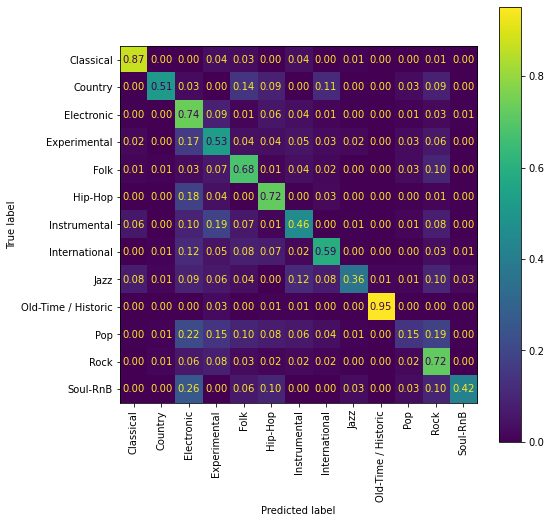

In [9]:
cl = MLPClassifier(random_state=RANDOM_STATE,alpha=0.01, hidden_layer_sizes=(400,), max_iter=1000)
cl.fit(X_train, y_train)
utils.run_classifier_and_report(cl, X_test, y_test)

## NO CHANGE - USELESS!